In [1]:
import numpy as np
import matplotlib.pyplot as plt

from randnn import ContinuousNN, get_lyapunov_spectrum
from randnn.plotting import plot_trajectory_avg

In [2]:
cont_nn = ContinuousNN(coupling_strength=1.1, n_dofs=1000)

In [3]:
trajectory, jacobians = cont_nn.run_or_load(n_steps=1000, return_jacobians=True)
cont_nn.save(trajectory, jacobians)

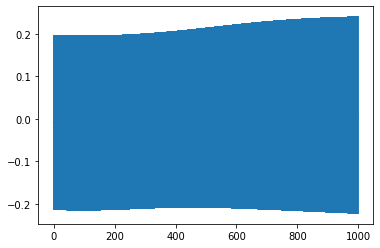

[[ 0.         -0.02347734 -0.00887362 ...  0.00420112 -0.04849815
   0.01216934]
 [ 0.08261809  0.         -0.02010004 ...  0.00778874 -0.02753083
  -0.04018211]
 [ 0.03425262  0.00604061  0.         ...  0.0500203   0.00410315
  -0.01376484]
 ...
 [-0.01865508 -0.03376751  0.02946267 ...  0.          0.0443649
   0.00291464]
 [ 0.05889694 -0.05994859  0.02783176 ...  0.00099141  0.
   0.00223939]
 [ 0.00722788 -0.03115663 -0.036417   ...  0.01969296  0.03656311
   0.        ]]
(1000, 1000, 1000)


In [4]:
plot_trajectory_avg(trajectory)
print(cont_nn.coupling_matrix)
print(jacobians.shape)

In [ ]:
lyapunov_spectrum = get_lyapunov_spectrum(jacobians)

Computing linear evolution: 975it [00:35, 13.61it/s]/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/lyapunov.py:33: RuntimeWarning: overflow encountered in matmul
  evolution[t + 1, :, :] = jacobian @ evolution[t]
/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/lyapunov.py:33: RuntimeWarning: invalid value encountered in matmul
  evolution[t + 1, :, :] = jacobian @ evolution[t]
Computing linear evolution: 1000it [00:38, 25.90it/s]
Decomposing evolution: 486it [01:15,  6.11it/s]

In [ ]:
print(lyapunov_spectrum)
plt.plot(lyapunov_spectrum)
plt.show()